投资组合预期收益率10%时A的权重： 0.3109
投资组合预期收益率10%时B的权重： 0.0859
投资组合预期收益率10%时C的权重： 0.0
投资组合预期收益率10%时D的权重： 0.5507
投资组合预期收益率10%时E的权重： 0.0525
投资组合可行集最左侧点的收益率： 0.0371
投资组合可行集最左侧点的波动率： 0.1645
市场组合的收益率： 0.1688
市场组合的波动率： 0.2442


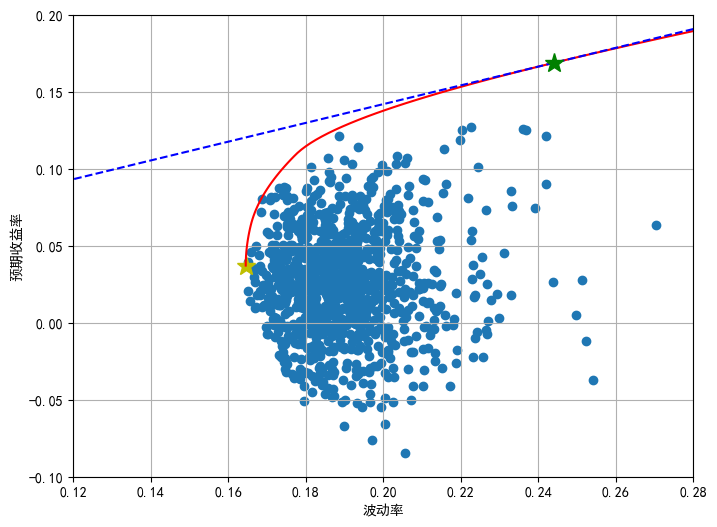

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

plt.rcParams['font.sans-serif'] = ['SimHei'] #中文显示问题
plt.rcParams['axes.unicode_minus'] = False #负数显示问题


# 投资组合的有效前沿
Rp_list = []
Vp_list = []
#设定投资组合各产品的均值
R_mean = np.array([0.20,0.08,-0.17,0.06,-0.04])
#设定投资组合的协方差
R_cov = pd.DataFrame({'A':[0.09,0.02,0.02,0.01,0.02],\
              'B':[0.02,0.12,0.04,0.02,0.03],\
              'C':[0.02,0.04,0.07,0.02,0.03],\
              'D':[0.01,0.02,0.02,0.04,0.02],\
              'E':[0.02,0.03,0.03,0.02,0.04]})
        

for i in np.arange(1000):
    #随机生成1000次投资组合的权重
    x = np.random.random(5)
    weights = x/sum(x)
    Rp_list.append(np.sum(weights*R_mean))
    Vp_list.append(np.sqrt(np.dot(weights,np.dot(R_cov,weights.T))))
    
   
plt.figure(figsize=(8,6))
plt.scatter(Vp_list,Rp_list)
plt.xlim(0.12,0.28)
plt.ylim(-0.1,0.2)
plt.xlabel('波动率')
plt.ylabel('预期收益率')
plt.grid('True')

'''
scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
fun:最优化的目标函数
x0：初始猜测值
method：优化方法，常用的方法有'BFGS','SLSQP'等
bounds：变量的边界值，元组形式
constraints：约束条件，字典形式({'type':'eq','fun':约束条件一},{'type':'ineq','fun':约束条件二})，'eq'表示等于0，'ineq'表示大于等于0
返回值
fun:目标函数值
sucess:布尔值，true成功
x:最优解
'''
# 求解最优权重
import scipy.optimize as sco

#定义一个最优化函数
def f(w):
    w = np.array(w) #设置投资组合每只股票的权重
    Rp_opt = np.sum(w*R_mean) #计算最优投资组合的预期收益率
    Vp_opt = np.sqrt(np.dot(w,np.dot(R_cov,w.T))) #计算最优投资组合的收益波动率
    return np.array([Rp_opt,Vp_opt])

def Vmin_f(w): 
    return f(w)[1]  #返回f(w)函数结果的波动率

#输入最优解条件，预期收益设定10%
cons = ({'type':'eq','fun':lambda x:np.sum(x)-1},{'type':'eq','fun':lambda x:f(x)[0]-0.1})
#输入边界条件
bnds = tuple((0,1) for x in range(len(R_mean)))
#生成初始权重（平均分配）
frist_weight = len(R_mean)*[1/len(R_mean)]

#求最值
result = sco.minimize(Vmin_f,frist_weight,method='SLSQP',bounds=bnds,constraints=cons)
# 获取最优化结果的权重
result['x'].round(4)
for i in np.arange(len(R_cov)):
    print('投资组合预期收益率10%时' + R_cov.columns[i] +'的权重：',result['x'][i].round(4))

#投资组合预期收益率10%时A的权重： 0.3109
#投资组合预期收益率10%时B的权重： 0.0859
#投资组合预期收益率10%时C的权重： 0.0
#投资组合预期收益率10%时D的权重： 0.5507
#投资组合预期收益率10%时E的权重： 0.0525

#求解有效前沿最左侧的点
#约束条件仅设置权重之和为1
cons_vmin = ({'type':'eq','fun':lambda x:np.sum(x)-1})
#求解全局最优解的权重
result_vmin = sco.minimize(Vmin_f,frist_weight,method='SLSQP',bounds=bnds,constraints=cons_vmin)
#求解投资组合的最左侧点的收益率
Rp_vmin = np.sum(R_mean*result_vmin['x'])
#求解投资组合的最左侧点的波动率
Vp_vmin = result_vmin['fun']

print('投资组合可行集最左侧点的收益率：',round(Rp_vmin,4))
print('投资组合可行集最左侧点的波动率：',round(Vp_vmin,4))

#投资组合可行集最左侧点的收益率： 0.0371
#投资组合可行集最左侧点的波动率： 0.1645

plt.plot(Vp_vmin,Rp_vmin,'y*',markersize=14)

#求解有效前沿构成的曲线
#设定投资组合的预期收益率
Rp_target = np.linspace(Rp_vmin,0.25,100)
#设定波动率列表
Vp_target = []
for r in Rp_target:
    cons_new = ({'type':'eq','fun':lambda x:np.sum(x)-1},{'type':'eq','fun':lambda x:f(x)[0]-r})
    result_new = sco.minimize(Vmin_f,frist_weight,method='SLSQP',bounds=bnds,constraints=cons_new)
    Vp_target.append(result_new['fun'])
    
plt.plot(Vp_target,Rp_target,'r-')

#CML（资本市场线）：考虑无风险资产的影响
def F(w):
    Rf = 0.02
    w = np.array(w)
    Rp_opt = np.sum(w*R_mean)
    Vp_opt = np.sqrt(np.dot(w,np.dot(R_cov,w.T)))
    SR = (Rp_opt-Rf)/Vp_opt #定义投资组合的夏普比率
    return np.array([Rp_opt,Vp_opt,SR])

def SRmin_F(w):
    return -F(w)[2] #求解最大的夏普比率就是求解负的最小值

#仅设定权重之和为1的约束条件
cons_SR = ({'type':'eq','fun':lambda x:np.sum(x)-1})
#求解最优权重
result_SR = sco.minimize(SRmin_F,frist_weight,method='SLSQP',bounds=bnds,constraints=cons_SR)

Rf= 0.02 #无风险利率
#最大夏普比率，即资本市场线斜率
slope = -result_SR['fun']
#市场组合的预期收益率
Rm = np.sum(R_mean*result_SR['x'])
#市场组合的波动率
Vm = (Rm-Rf)/slope

print('市场组合的收益率：',round(Rm,4))
print('市场组合的波动率：',round(Vm,4))

#市场组合的收益率： 0.1688
#市场组合的波动率： 0.2442

#画出资本市场线
Rp_cml = np.linspace(0.02,0.25)
Vp_cml = (Rp_cml - Rf)/slope
plt.plot(Vp_cml,Rp_cml,'b--')
plt.plot(Vm,Rm,'g*',markersize=14)
